In [593]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV,KFold

from sklearn.preprocessing import LabelEncoder, StandardScaler

import xgboost as xgb
import warnings
import joblib

In [5]:
data = pd.read_csv('Crop_Dataset.csv')

In [9]:
### checking for missing values
data.isnull().any()

N                       False
P                       False
K                       False
temperature             False
humidity                False
ph                      False
rainfall                False
Total_Nutrients         False
Temperature_Humidity    False
Log_Rainfall            False
Label                   False
Label_Encoded           False
dtype: bool

In [20]:
### classes appear to be evenly distributed
data.Label.value_counts()

Label
wheat               100
barley              100
rapeseed            100
potatoes            100
apples              100
strawberries        100
blackcurrants       100
pears               100
raspberries         100
plums               100
cherries            100
beets               100
carrots             100
turnips             100
peas                100
beans               100
cabbage             100
brussels_sprouts    100
cauliflower         100
spinach             100
lettuce             100
tomatoes            100
Name: count, dtype: int64

In [589]:
nutr_cols = ['N', 'P', 'K', "Total_Nutrients", "rainfall"]

env_cols = [i for i in cols if i not in nutr_cols]

In [590]:
df = data.copy()

X = df.drop(["Label", "Label_Encoded", "rainfall"], axis=1)
y = df["Label"]
y_enc = df["Label_Encoded"]

In [591]:
### train test split for eda
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [598]:
### train test split for model building
### drop rainfall and keep lo_rainfall
X_train, X_test, y_train, y_test = train_test_split(X[env_cols], y, test_size=0.2, random_state=42)

In [594]:
scaler = StandardScaler()

In [600]:
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [601]:
X_test

temperature  humidity        ph  Temperature_Humidity  Log_Rainfall
0       0.769240  1.052324 -0.376199              1.361553     -2.183394
1       0.117852  0.679569 -0.280130              0.597577     -1.060552
2       3.494241  0.989743  0.602097              3.172800      0.460733
3       1.709858  0.862741  0.451914              1.809842      0.184125
4      -0.523784  0.869515 -1.128425              0.327919      0.520252
..           ...       ...       ...                   ...           ...
435    -0.757731  0.394182  0.033312             -0.156502      2.070475
436    -0.560413  0.481915  1.066275              0.023304      1.954856
437    -0.387924  0.351341  1.613114              0.029456     -0.371075
438    -0.518190  0.173120 -0.467411             -0.176528     -0.511238
439    -1.284401 -1.746457 -0.458176             -1.763762      1.010894

[440 rows x 5 columns]

# EDA

In [459]:
cols = X_train.columns

In [460]:
dt = pd.concat([x_train.copy(), y_train.copy()], axis=1)

[]

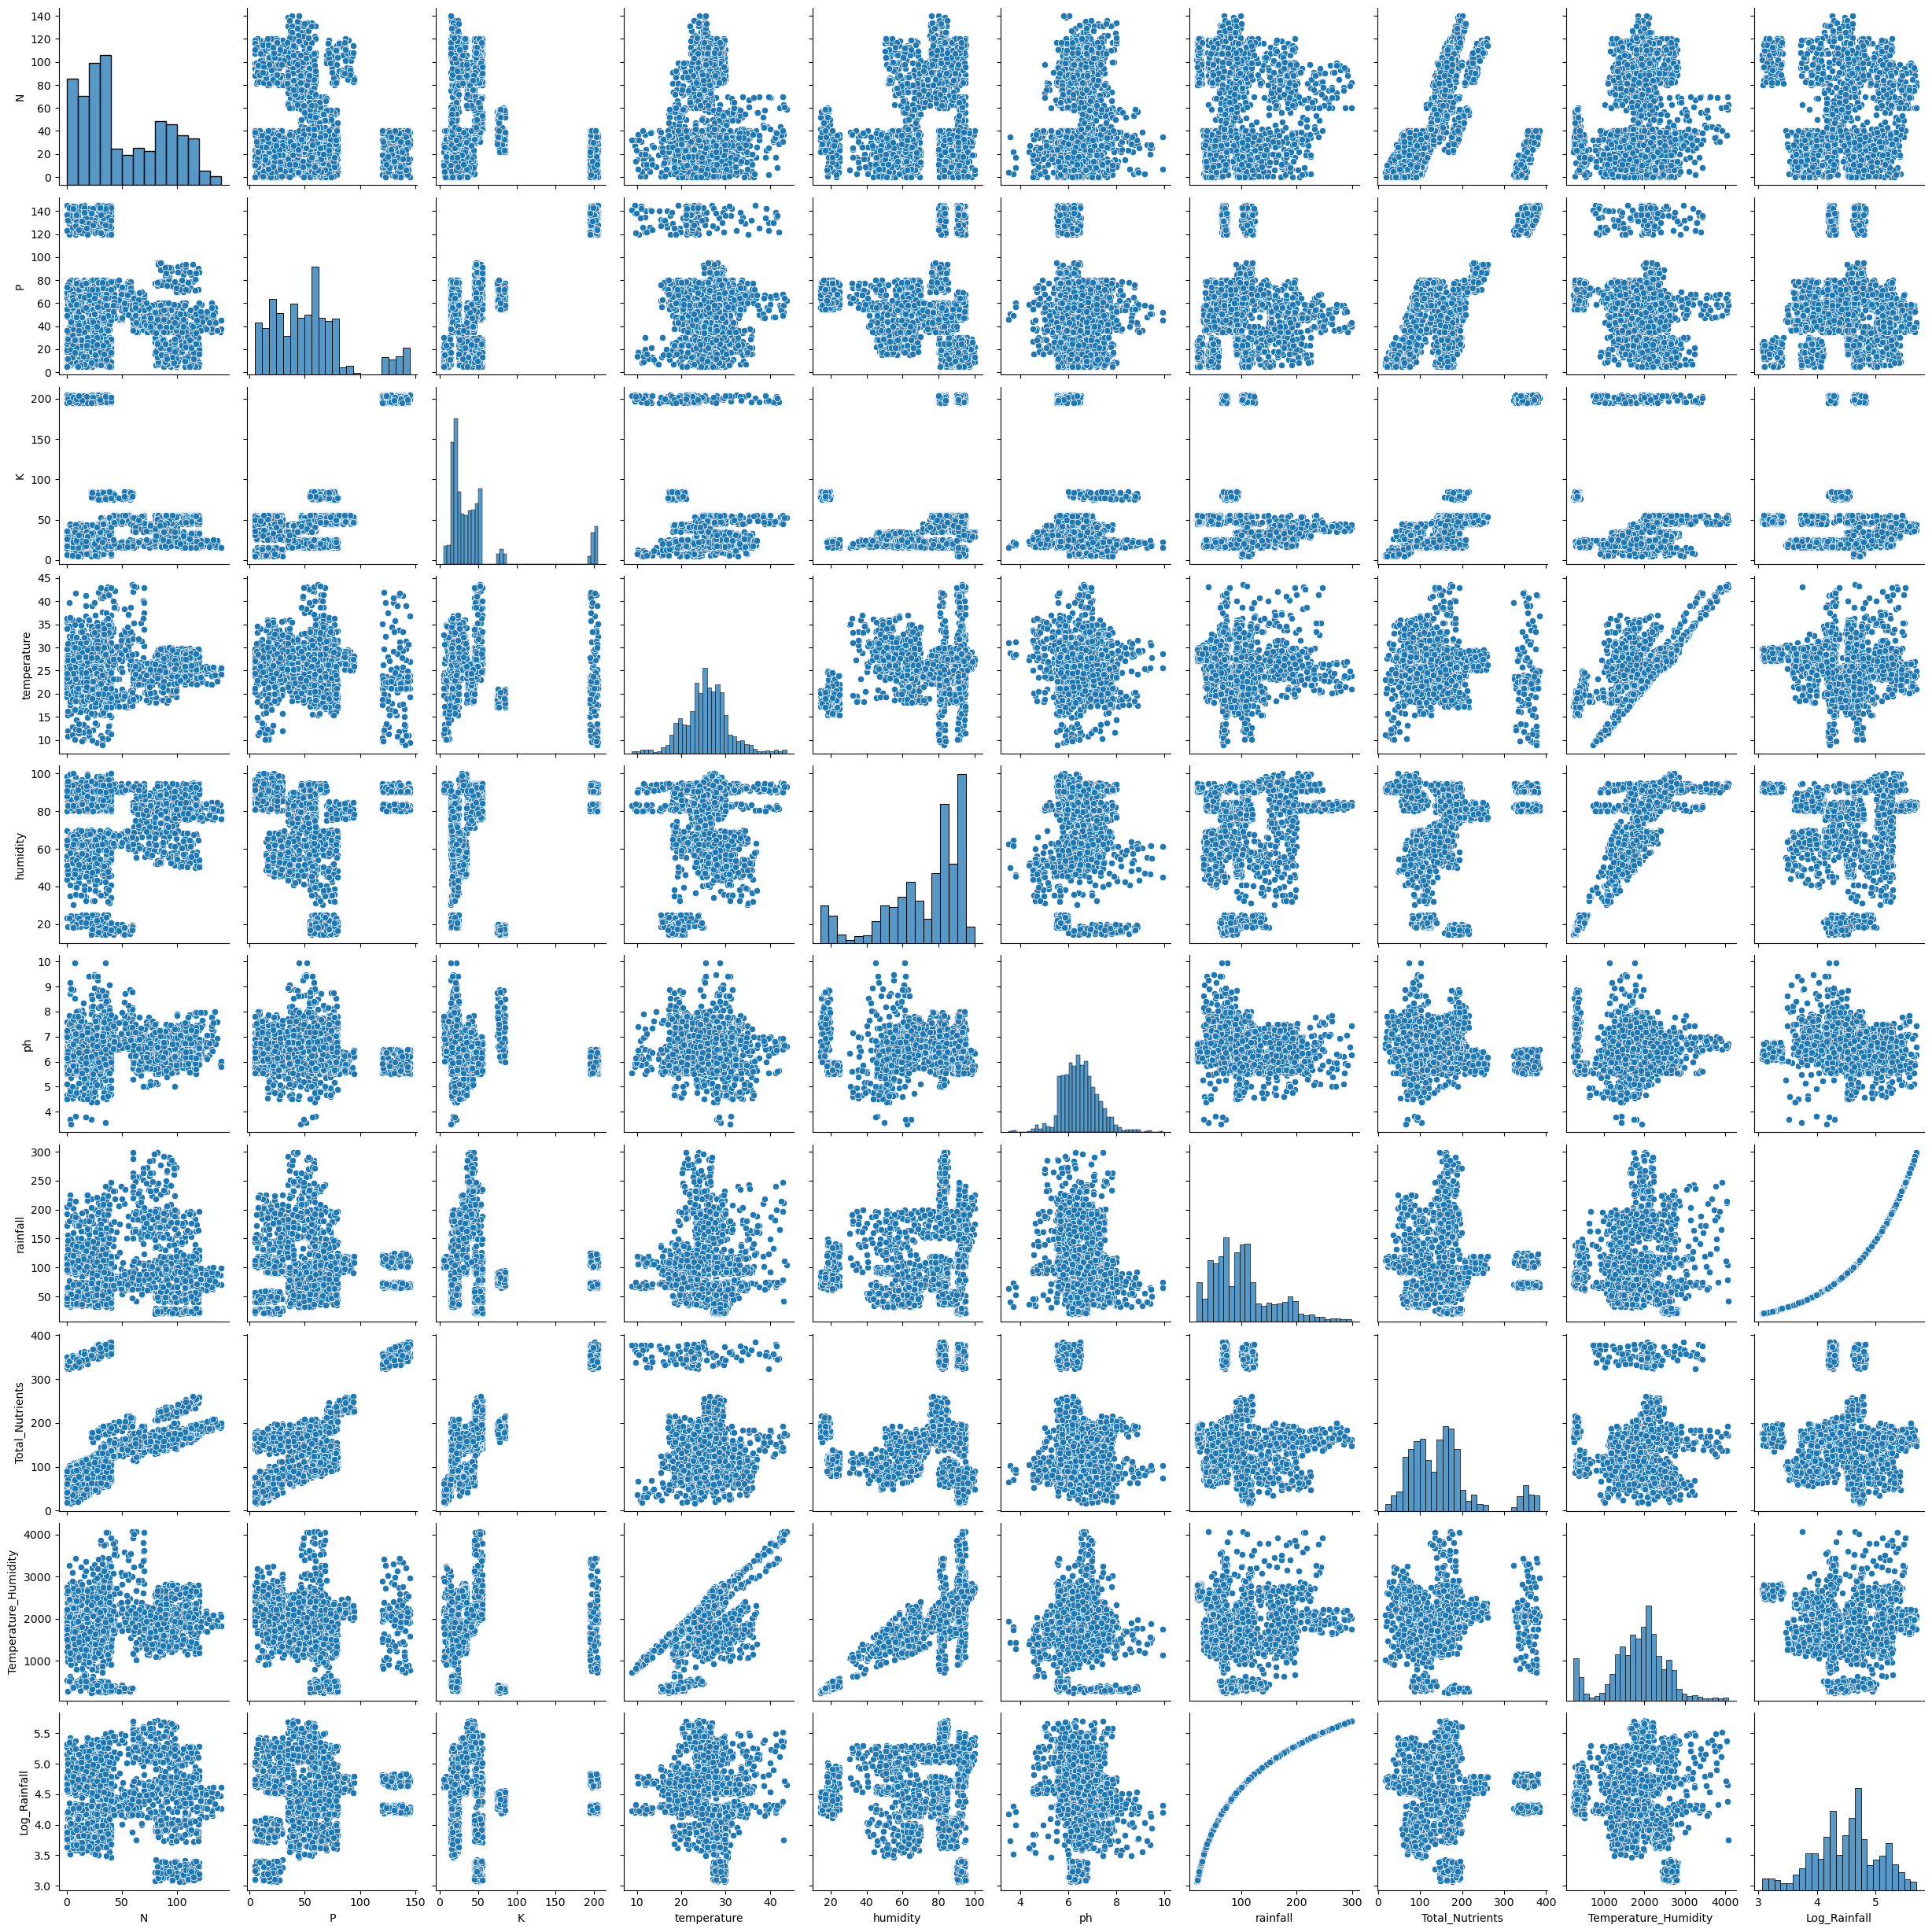

In [461]:
sns.pairplot(dt)
plt.plot()

In [68]:
temp

Label
blackcurrants        45.476744
apples               70.068493
turnips              76.103896
beets                76.209877
cabbage              87.790123
brussels_sprouts     90.328947
peas                106.685393
cauliflower         108.688312
spinach             109.025000
beans               127.625000
barley              145.784810
strawberries        158.727273
tomatoes            159.433735
rapeseed            165.961039
plums               166.123457
wheat               166.901235
raspberries         168.084337
potatoes            183.614458
lettuce             188.432432
carrots             232.253165
pears               354.363636
cherries            355.848837
Name: Total_Nutrients, dtype: float64

[]

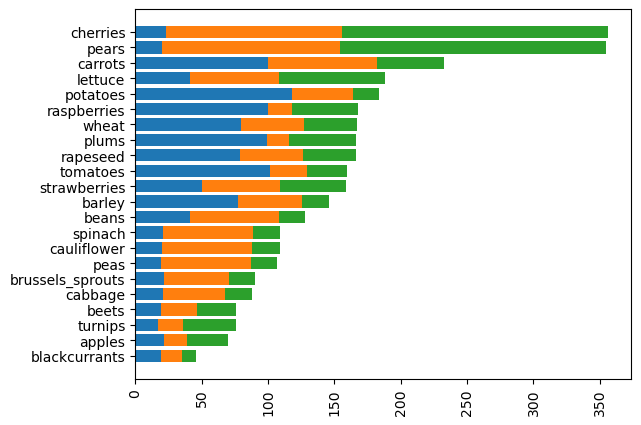

In [95]:
temp = dt.groupby("Label")[["Total_Nutrients", "N", "P", "K"]].mean().sort_values(by="Total_Nutrients")

#plt.barh(y=temp.index, width=temp.Total_Nutrients)
plt.barh(y=temp.index, width=temp.N)
plt.barh(y=temp.index, width=temp.P, left=temp.N)
plt.barh(y=temp.index, width=temp.K, left=temp.N + temp.P)
plt.xticks(rotation=90)
plt.plot()

In [90]:
temp

Total_Nutrients           N           P           K
Label                                                                
blackcurrants           45.476744   19.104651   16.360465   10.011628
apples                  70.068493   21.753425   17.452055   30.863014
turnips                 76.103896   17.259740   18.623377   40.220779
beets                   76.209877   19.209877   27.061728   29.938272
cabbage                 87.790123   20.629630   47.320988   19.839506
brussels_sprouts        90.328947   21.776316   48.578947   19.973684
peas                   106.685393   19.089888   68.258427   19.337079
cauliflower            108.688312   20.376623   67.948052   20.363636
spinach                109.025000   21.275000   67.625000   20.125000
beans                  127.625000   40.912500   67.600000   19.112500
barley                 145.784810   77.531646   48.417722   19.835443
strawberries           158.727273   50.129870   58.571429   50.025974
tomatoes               159.433735  101.301205   28.385542   29.746988
rapeseed               165.961039   79.000000   47.051948   39.909091
plums                  166.123457   98.962963   17.172840   49.987654
wheat                  166.901235   79.641975   47.259259   40.000000
raspberries            168.084337  100.301205   17.457831   50.325301
potatoes               183.614458  118.156627   45.915663   19.542169
lettuce                188.432432   40.918919   67.581081   79.932432
carrots                232.253165  100.215190   81.822785   50.215190
pears                  354.363636   19.961039  134.597403  199.805195
cherries               355.848837   22.860465  132.813953  200.174419

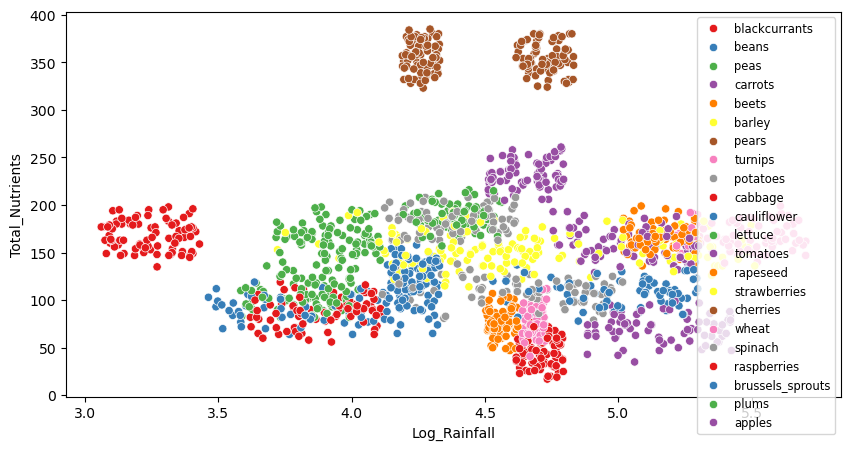

In [106]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=dt, x="Log_Rainfall", y="Total_Nutrients", hue="Label", palette="Set1")
plt.legend(loc='upper right', fontsize='small')
plt.show()

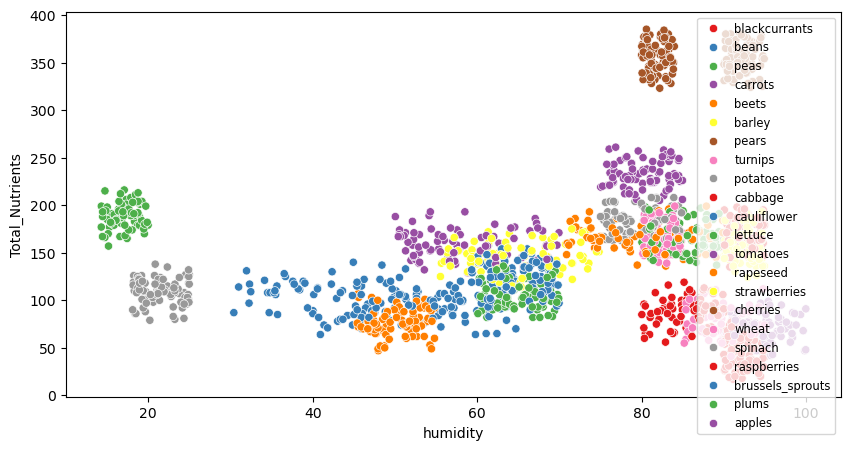

In [108]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=dt, x="humidity", y="Total_Nutrients", hue="Label", palette="Set1")
plt.legend(loc='upper right', fontsize='small')
plt.show()

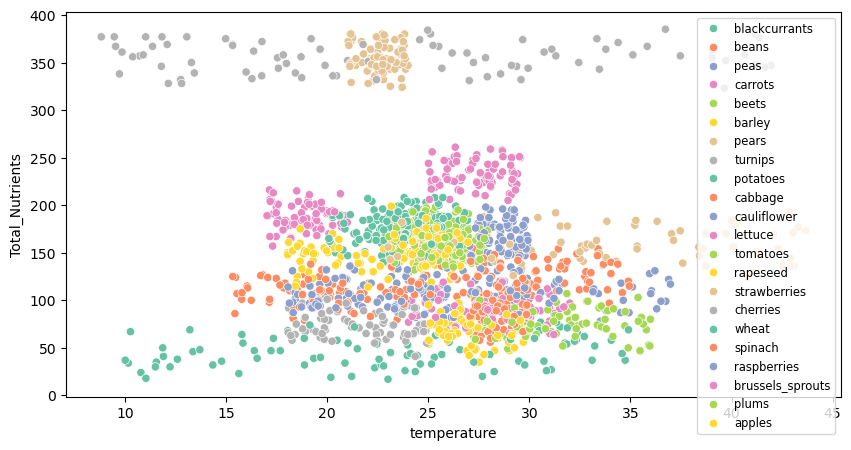

In [111]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=dt, x="temperature", y="Total_Nutrients", hue="Label", palette="Set2")
plt.legend(loc='upper right', fontsize='small')
plt.show()

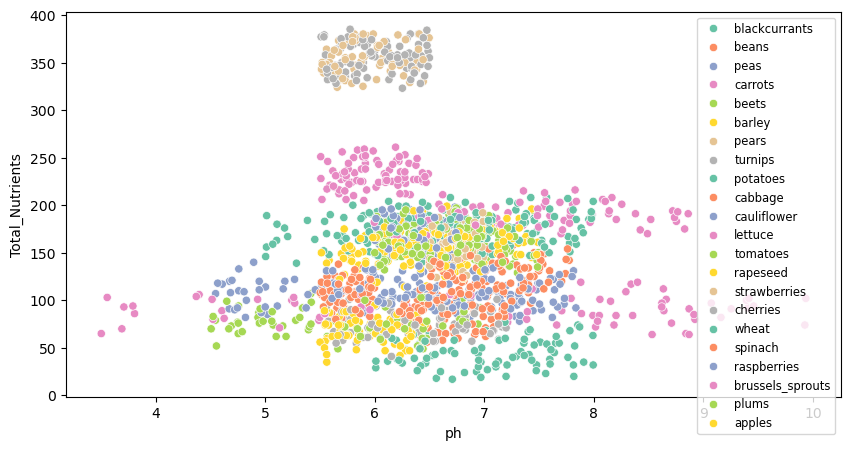

In [114]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=dt, x="ph", y="Total_Nutrients", hue="Label", palette="Set2")
plt.legend(loc='upper right', fontsize='small')
plt.show()

# Model building

In [612]:
def eval(model, y_test=y_test, y_train=y_train, X_test=X_test, X_train=X_train):
    
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    test_acc = accuracy_score(y_test, y_pred_test)
    train_acc  = accuracy_score(y_train, y_pred_train)

    row = {'test_acc': test_acc,
      'train_acc': train_acc}

    return row


## random forest

In [613]:
forest_clf = RandomForestClassifier(random_state=42, max_depth=5)

In [614]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [615]:
eval(forest_clf)

{'test_acc': 0.8590909090909091, 'train_acc': 0.8909090909090909}

In [605]:
param_grid = {
    'max_depth': [5, 6, 7],
    'max_features': ['sqrt'],
    'min_samples_leaf': [2, 3, 4],
    'n_estimators': [250, 300]
}

In [606]:
forest_clf_best = RandomForestClassifier(random_state=42)

In [607]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
forest_grid = GridSearchCV(estimator = forest_clf_best, param_grid = param_grid, 
                          cv = cv, n_jobs = -1, verbose = 2)

In [608]:
score = forest_grid.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [609]:
score.best_params_

{'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'n_estimators': 300}

In [616]:
forest_clf_best = score.best_estimator_

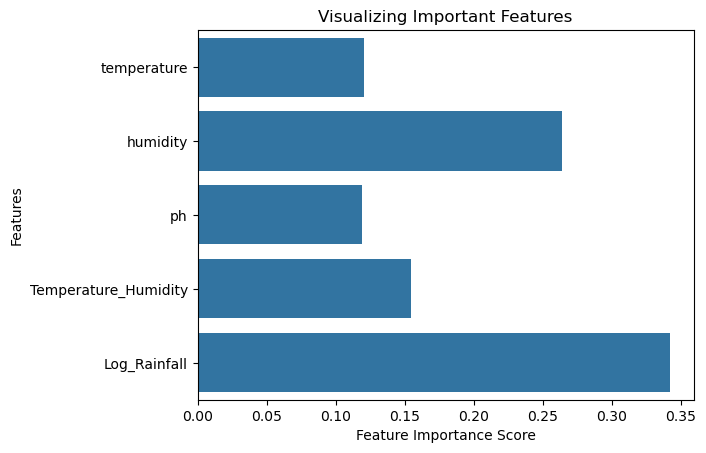

In [617]:
feature_imp1 = forest_clf_best.feature_importances_

sns.barplot(x=feature_imp1, y=X_train.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [619]:
eval(forest_clf_best)

{'test_acc': 0.9272727272727272, 'train_acc': 0.9613636363636363}

In [620]:
def get_crops(input_data, model):
    probs = model.predict_proba(input_data)
    predictions_idx = np.argsort(-probs)[:, :3]
    predictions = [model.classes_[i] for i in predictions_idx]
    return predictions

In [621]:
get_crops(X_test.iloc[:2], forest_clf_best)

[array(['raspberries', 'apples', 'blackcurrants'], dtype=object),
 array(['plums', 'turnips', 'rapeseed'], dtype=object)]

In [622]:
y_test.iloc[:2]

1451    raspberries
1334          plums
Name: Label, dtype: object

In [623]:
forest_clf_best.predict(X_test.iloc[:2])

array(['raspberries', 'plums'], dtype=object)

## xgboost

In [624]:
params = {
    'max_depth': 3,
    'learning_rate': 0.01,
    'n_estimators': 100,
    'objective': 'multi:softmax',  # For multiclass classification
    'num_class': len(set(y_train))  # Number of unique classes in y_train
}

In [625]:
xgb_clf = xgb.XGBClassifier(**params)

In [626]:
label_encoder = LabelEncoder()

In [627]:
y_train_enc = label_encoder.fit_transform(y_train.copy())

In [628]:
xgb_clf.fit(X_train, y_train_enc)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=22,
              num_parallel_tree=None, ...)

In [629]:
eval(xgb_clf, y_test=label_encoder.transform(y_test.copy()), y_train=label_encoder.transform(y_train.copy()))

{'test_acc': 0.9113636363636364, 'train_acc': 0.959659090909091}

In [630]:
param_grid = {
    'max_depth': [3, 6, 9],           
    'learning_rate': [0.1, 0.01],     
    'n_estimators': [100, 200],      
    'subsample': [0.8, 1.0],         
    'colsample_bytree': [0.8, 1.0]   
}


In [631]:
xgb_clf_best = xgb.XGBClassifier(random_state=42)

In [632]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
xgb_grid = GridSearchCV(estimator = xgb_clf_best, param_grid = param_grid, 
                          cv = cv, n_jobs = -1, verbose = 2)

In [633]:
score = xgb_grid.fit(X_train, y_train_enc)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [634]:
score.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 100,
 'subsample': 0.8}

In [635]:
xgb_clf_best = score.best_estimator_

In [636]:
eval(xgb_clf_best, y_test=label_encoder.transform(y_test.copy()), y_train=label_encoder.transform(y_train.copy()))

{'test_acc': 0.9568181818181818, 'train_acc': 0.9971590909090909}

In [637]:
res = get_crops(X_test.iloc[:10], xgb_clf_best)

In [638]:
[label_encoder.inverse_transform(i) for i in res]

[array(['raspberries', 'blackcurrants', 'cherries'], dtype=object),
 array(['plums', 'cabbage', 'cherries'], dtype=object),
 array(['strawberries', 'blackcurrants', 'carrots'], dtype=object),
 array(['strawberries', 'blackcurrants', 'carrots'], dtype=object),
 array(['pears', 'blackcurrants', 'turnips'], dtype=object),
 array(['beets', 'cauliflower', 'carrots'], dtype=object),
 array(['pears', 'turnips', 'blackcurrants'], dtype=object),
 array(['brussels_sprouts', 'barley', 'plums'], dtype=object),
 array(['cabbage', 'cherries', 'plums'], dtype=object),
 array(['peas', 'barley', 'plums'], dtype=object)]

In [639]:
y_test.iloc[:10]

1451         raspberries
1334               plums
1761        strawberries
1735        strawberries
1576               pears
1110               beets
1594               pears
530     brussels_sprouts
651              cabbage
819                 peas
Name: Label, dtype: object

In [640]:
label_encoder.inverse_transform(xgb_clf_best.predict(X_test.iloc[:10]))

array(['raspberries', 'plums', 'strawberries', 'strawberries', 'pears',
       'beets', 'pears', 'brussels_sprouts', 'cabbage', 'peas'],
      dtype=object)

# model evaluation

In [641]:
### using random forest xgb overfitted

In [736]:
top_three_crops = get_crops(X_test, forest_clf_best)

In [737]:
top_three_crops

[array(['raspberries', 'apples', 'blackcurrants'], dtype=object),
 array(['plums', 'turnips', 'rapeseed'], dtype=object),
 array(['strawberries', 'blackcurrants', 'turnips'], dtype=object),
 array(['strawberries', 'blackcurrants', 'carrots'], dtype=object),
 array(['pears', 'turnips', 'blackcurrants'], dtype=object),
 array(['beets', 'cauliflower', 'brussels_sprouts'], dtype=object),
 array(['pears', 'turnips', 'blackcurrants'], dtype=object),
 array(['brussels_sprouts', 'barley', 'peas'], dtype=object),
 array(['cabbage', 'plums', 'strawberries'], dtype=object),
 array(['peas', 'barley', 'brussels_sprouts'], dtype=object),
 array(['beans', 'brussels_sprouts', 'peas'], dtype=object),
 array(['apples', 'rapeseed', 'strawberries'], dtype=object),
 array(['turnips', 'blackcurrants', 'pears'], dtype=object),
 array(['rapeseed', 'wheat', 'potatoes'], dtype=object),
 array(['apples', 'strawberries', 'blackcurrants'], dtype=object),
 array(['blackcurrants', 'strawberries', 'turnips'], dtype=o

In [738]:
len(top_three_crops)

440

In [739]:
unique_arrays = [sorted(list(crops)) for crops in top_three_crops]

In [740]:
unique_arrays = list(unique_arrays)

In [741]:
unique_arrays = list({tuple(crops) for crops in unique_arrays})

In [742]:
len(unique_arrays)

66

In [743]:
### there are 66 unique combination of three crops given by the model from test data

In [745]:
### here we consider following combination
selected = unique_arrays[0]
selected

('carrots', 'cherries', 'potatoes')

In [746]:
dt["cluster"] = dt['Label'].apply(lambda x: True if x in selected else False) == True

In [747]:
cols

Index(['temperature', 'humidity', 'ph', 'rainfall', 'Temperature_Humidity',
       'Log_Rainfall'],
      dtype='object')

In [748]:
nutr_cols = ['N', 'P', 'K', "Total_Nutrients", "rainfall"]

env_cols = [i for i in cols if i not in nutr_cols]

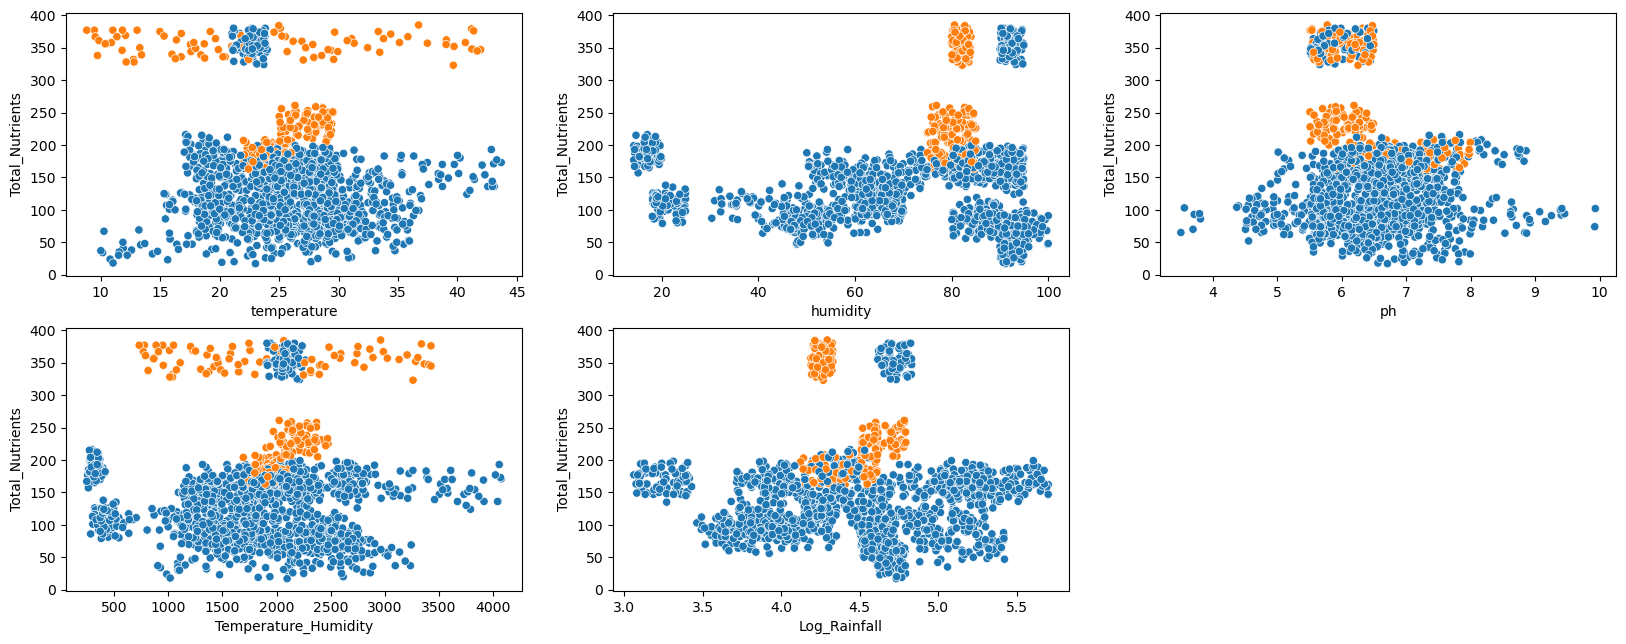

In [749]:
plt.figure(figsize=(20, len(env_cols)*1.5))
for idx, column in enumerate(env_cols):
    plt.subplot(len(env_cols)//3+1, 3, idx+1)
    sns.scatterplot(y="Total_Nutrients", x=column, data=dt, legend=False, hue="cluster")

In [750]:
env_cols.append('cluster')

[]

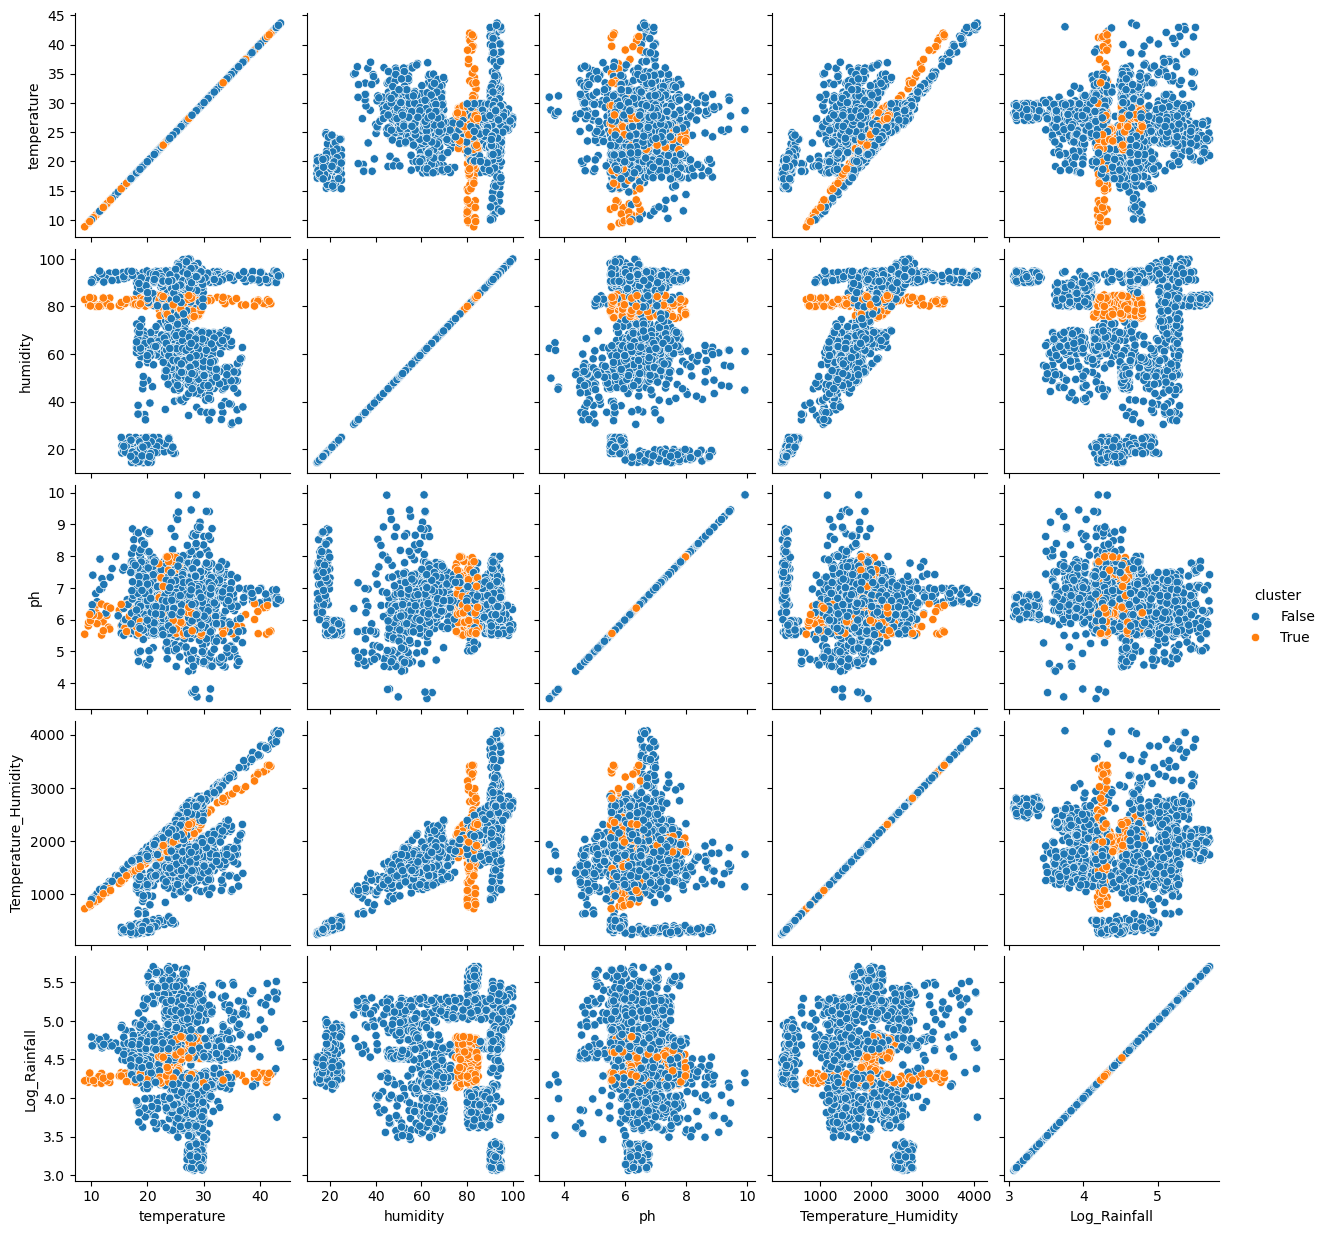

In [751]:
sns.pairplot(dt[env_cols], hue="cluster", diag_kind=None)
plt.plot()

# saving model

In [655]:
joblib.dump(forest_clf_best, "forest_model.joblib")

['forest_model.joblib']

In [657]:
model = joblib.load("forest_model.joblib")

In [662]:
y_pred = model.predict(X_test.iloc[:100])

In [663]:
accuracy_score(y_test.iloc[:100], y_pred)

0.9